Fieldtrip: KIT oddball analysis with source localization using beamformer
=========================================================================

Lead authors: Hadi Zaatiti hadi.zaatiti@nyu.edu, Osama Abdullah, osama.abdullah@nyu.edu

This notebook is to be run in MATLAB, while having fieldtrip library installed.
It is a pipeline for processing the `oddball` experiment raw data acquired from KIT-MEG system at NYUAD, run frequency analysis in source space, source localization using Beamformer technique.
The `oddball` code experiment in Psychtoolbox can be found here:

[Oddball experiment page](https://meg-pipeline.readthedocs.io/en/latest/3-experimentdesign/experiments/6-exp-sound.html)

[Oddball PsychToolBox code for KIT system](https://github.com/hzaatiti-NYU/meg-pipeline/blob/bc99896a4e271b902282b1432c12e338060f4fa0/experiments/psychtoolbox/sound/oddball/run_oddball_KIT.m)

Importing data and preprocessing
--------------------------------
The data used in this notebook is hosted on `NYU BOX`. Permissions are given upon request.

- Install the BOX app from [here](https://www.box.com/resources/downloads)
- Set an environment variable with name `MEG_DATA` to the path of the Data folder e.g.,
    - `C:\Users\user_name\Box\MEG\Data`
    - or `C:\Users\user_name\Box\Data`

Each experiment run using the KIT system generates a `.con` and several `.mrk`. Find more details about these files in the other chapters.
In the following setup the variables pointing to your data, headshape and MRI scan.

In [64]:
% Read the environment variable to NYU BOX
MEG_DATA_FOLDER = getenv('MEG_DATA');

% Set path to KIT .con file of sub-03
DATASET_PATH = [MEG_DATA_FOLDER,'oddball\sub-03\meg-kit\sub-03-raw-kit.con'];

% Set path to computed .mat variables, these has been obtained by executing this pipeline and 
% will allow you to skip steps if you wish to execute a particular cell
LOAD_PATH = [MEG_DATA_FOLDER, 'oddball\derivatives\kit_oddball_pipeline_fieldtrip\sub-03\'];

% Experiment your own test and save your variables in a folder of your choice, choose the folder where to save your variables
% We will also use it to copy variables from LOAD_PATH and use them in the notebook if needed
SAVE_PATH = 'docs\source\5-pipeline\notebooks\fieldtrip\fieldtrip_oddball_kit_data\';

% It is important that you use T1.mgz instead of orig.mgz as T1.mgz is normalized to [255,255,255] dimension
MRI_FILE         = fullfile([MEG_DATA_FOLDER,'oddball\sub-03\anat\sub-003\sub-003\mri\T1.mgz']);
 
laser_surf      = fullfile([MEG_DATA_FOLDER,'oddball\sub-03\anat\digitized-headshape\sub-03-basic-surface.txt']);
%The cleaned stylus points removes the last three columns (dx, dx, dz) and
%keeps only x,y,z
laser_points    = [MEG_DATA_FOLDER, 'oddball\sub-03\anat\digitized-headshape\sub-03-stylus-cleaned.txt'];
mrkfile1        = [MEG_DATA_FOLDER,'oddball\sub-03\meg-kit\240524-1.mrk'];
mrkfile2        = [MEG_DATA_FOLDER, 'oddball\sub-03\meg-kit\240524-2.mrk'];

try
    cd(SAVE_PATH)
catch
end

Read the digitized headshape and stylus points.
More information on those in other chapters of the documentation.
The `read_head_shape_laser` function can be found in `pipeline/field_trip_pipelines/matlab_functions`. You can add it to your MATLAB path.

In [22]:
headshape   = read_head_shape_laser(laser_surf,laser_points);

shape = struct with fields:
      pos: [1681x3 double]
      fid: [1x1 struct]
    label: []

In [24]:
headshape   = ft_convert_units(headshape, 'mm');

Plot initial digitized headshape.

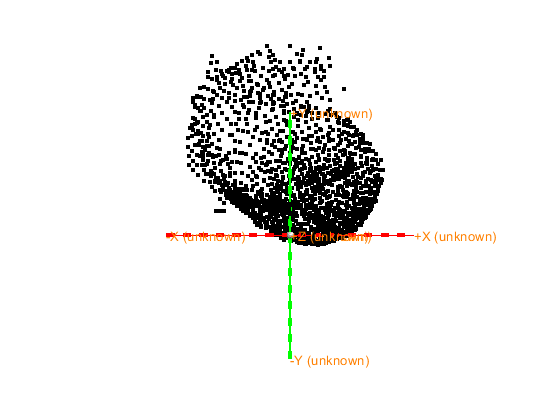

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm


ans = struct with fields:
      pos: [1681x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'

In [25]:
ft_determine_coordsys(headshape, 'interactive', 'no')

Let us now define a coordinate system for the digitized headshape based on the known fiducials from the laser_shape.
CTF is an ALS coordinate system meaning:
- the X-coordinate axis points to A (Anterior)
- the Y-coordinate axis points to L (Left)
- the Z-coordinate axis points to S (Superior)

The first, 4th and 5th fiducials in the stylus points correspond to Nasion, Left Ear and Right Ear.
More information on digitized headshape fiducials is found [here.](https://meg-pipeline.readthedocs.io/en/latest/2-operationprotocol/operationprotocol.html)
Define the transformation as follows:

In [26]:
laser2ctf = ft_headcoordinates(headshape.fid.pos(1,:),headshape.fid.pos(4,:),headshape.fid.pos(5,:),'ctf');

Apply the transformation to the digitized headshape.

In [27]:
headshape = ft_transform_geometry(laser2ctf, headshape)

headshape = struct with fields:
      pos: [1681x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'

Plot to verify the new coordinate system and ensure that the new coordinate system is indeed CTF.

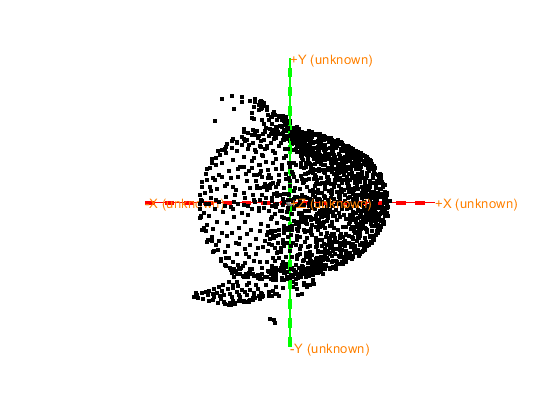

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm


ans = struct with fields:
      pos: [1681x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'

In [28]:
ft_determine_coordsys(headshape, 'interactive', 'no')

Apply a z-plane cut to remove unncessary points from digitized-headshape under a certain z-value.

Use the mouse to rotate the geometry, and click "redisplay" to update the light.
Close the figure when you are done.
the template coordinate system is unknown, selecting the viewpoint is not possible
The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm

Press "h" to show this help.
Press "q" or close the window when you are done.
Press "v" to update the light position.
the call to "ft_interactiverealign" took 2 seconds


ans = logical
   1

ans = logical
   1

keeping 1251 and removing 430 vertices in the mesh
the call to "ft_defacemesh" took 2 seconds


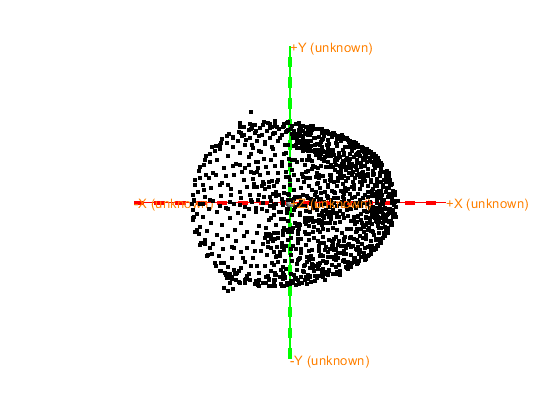

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm


ans = struct with fields:
      pos: [1251x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'
      cfg: [1x1 struct]

In [29]:
% Deface the laser mesh under a certain plan (change planecut) Define the configuration for ft_defacemesh
planecut = -5;
cfg = [];
cfg.method    = 'plane';       % Use a plane for exclusion
cfg.translate = [0 0 planecut]; % A point on the plane (adjust z_value as needed)
cfg.rotate    = [0 0 0];       % Rotation vector, modify if the plane is not axis-aligned
cfg.selection = 'outside';     % Remove points below the plane

% Apply ft_defacemesh to remove points below the plane
mesh = ft_defacemesh(cfg, headshape);

% Plot the resulting mesh to check the results
figure
ft_determine_coordsys(mesh, 'interactive', 'no')

When you are happy with the result set your headshape as the defaced mesh. Notice the new `headshape.pos` has less points after defacing.

In [30]:
headshape = mesh
save headshape headshape

headshape = struct with fields:
      pos: [1251x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'
      cfg: [1x1 struct]

Read subjets MRI T1w scan.

In [66]:
%% read mri and mri-headshape
mri = ft_read_mri(MRI_FILE); % read mri file
mri = ft_convert_units(mri, 'mm'); %make sure units mm
save mri mri

extracting compressed dataset to C:\Users\hz3752\AppData\Local\Temp\x2001df3da49bb0c143cbbaaf3ffbe706\...
extracted dataset is located at C:\Users\hz3752\AppData\Local\Temp\x2001df3da49bb0c143cbbaaf3ffbe706\T1


Inspect visually the MRI.

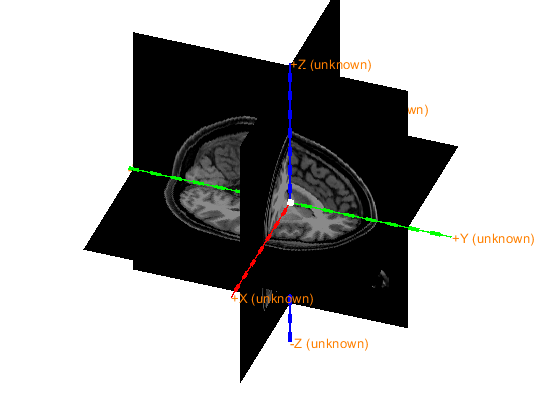

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm


In [45]:
mri = ft_determine_coordsys(mri, 'interactive', 'no');

In [ ]:
Notice that the MRI is not in CTF coordinate system (which is an ALS type).

In [46]:
%Skip this cell if you had already set the MRI to CTF in a previous run and saved the result in mri_init
cfg             = [];
cfg.method      = 'interactive';
cfg.coordsys    = 'ctf'; %use CTF coordinates (pos x toward nose, +y to left)
mri_init = ft_volumerealign(cfg,mri)
ft_determine_coordsys(mri_init, 'interactive', 'no'); % sanity check, should be CTF

save mri_init mri_init

Error connecting to MATLAB. Check the status of MATLAB by clicking the "Open MATLAB" button. Retry after ensuring MATLAB is running successfully

The MRI data is now in the CTF coordinate system (based on ALS).
Plot and check the final result.

The positive x-axis is pointing towards anterior
The positive y-axis is pointing towards the left
The positive z-axis is pointing towards superior


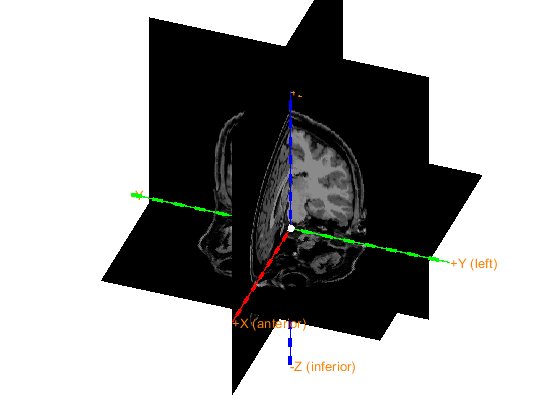

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm


In [48]:
load mri_init mri_init

ft_determine_coordsys(mri_init, 'interactive', 'no');

Coregistration: Laser Headshape and sensors
-------------------------------------------

Now we would like to coregister the sensors with the digitized headshape.
Each `.mrk` file holds the positions of five points obtained from HPI coils that had been placed on the participants head in specific locations.
Read more about the positions of the points in https://meg-pipeline.readthedocs.io/en/latest/2-operationprotocol/operationprotocol.html

The order in which they appear in a `.mrk` are the following:



In [31]:
%% Align MEG Dewar to Laser scan Head model
% now we want to align the 3 markers in the *.con file with the 3 markers
% in the headshape, where 1:5 markers match to the 4:9 headshape
% fiducials
mrk1 = ft_read_headshape(mrkfile1);
mrk1 = ft_convert_units(mrk1, headshape.unit);
mrk2 = ft_read_headshape(mrkfile2);
mrk2 = ft_convert_units(mrk2, headshape.unit);

The input file is an original one: only marker-coil positions are loaded
The input file is an original one: only marker-coil positions are loaded


mrk1 has been recorded prior to the experiment and mrk2 just after the end.
Compute the average positions of the five points over both time points.

In [32]:
% Define the average marker positions, mrk1 correspond to HPI coils at the
% beginning and end of the experiment
mrka = mrk1;
mrka.fid.pos = (mrk1.fid.pos+mrk2.fid.pos)/2;

In [33]:
% pcoils holds all the marker points 
p_coils = mrka.fid.pos(1:5,:);
p_headscan = headshape.fid.pos;

Compute the transformation to bring both HPI coils positions and headscan fiducials to the same coordinate system.
Note: there is no HPI coil on the nasion, but they are on forehead, so the X-axis will point to the forehead and not the nasion.

In [34]:
t1 = ft_headcoordinates(p_coils(1,:), p_coils(2,:), p_coils(3,:), 'ctf');%J p_coils(1,:) is not exactly the nasion, so do not interpret the X-axis as going through the nasion
t2 = ft_headcoordinates(p_headscan(6,:), p_headscan(4,:), p_headscan(5,:), 'ctf');%J

Compute the quotient transformation allowing to coregister the HPI coils poisition to laser fiducials.

In [35]:
% t2\t1 is interpreted as the transformation t that, if you apply t to a
% point, then you apply t1 on the resulting point, becomes as if you
% applied t2 on that point, this means the composition t1(t(point)) = t2

transform_mrk2laser = t2\t1;
% p1t = ft_warp_apply(transform_mrk2laser, p1)

grad = ft_read_sens(DATASET_PATH,'senstype','meg');
grad = ft_convert_units(grad,'mm');
grad = ft_transform_geometry(transform_mrk2laser, grad);


save grad grad

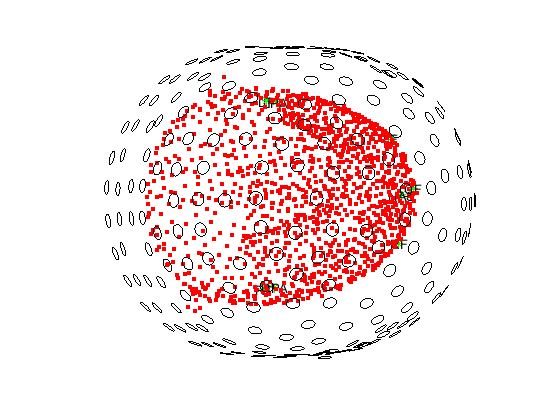

In [37]:
figure
ft_plot_headshape(headshape)
hold on
ft_plot_sens(grad)
hold off

Plot with different views `view([azimuth, elevation])` where azimuth defines the rotation of object around the Z-axis, and elevation defines the angle of elevation of the observing camera.

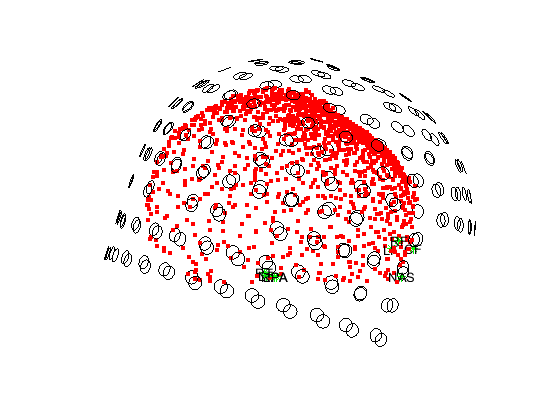

In [66]:
view([0 0])

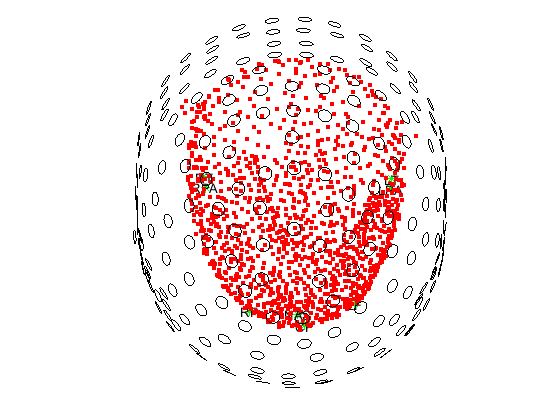

In [68]:
view([90 90]) % Top view

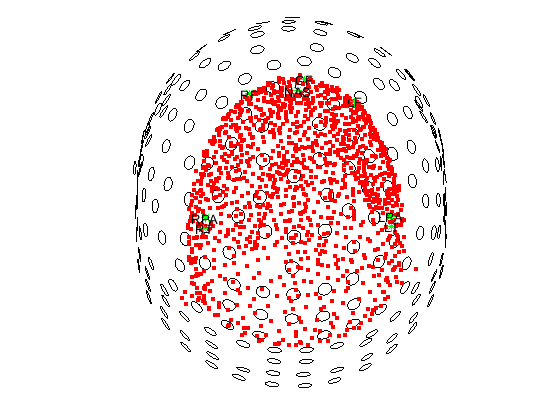

In [71]:
view([90 -90]) % Bottom view

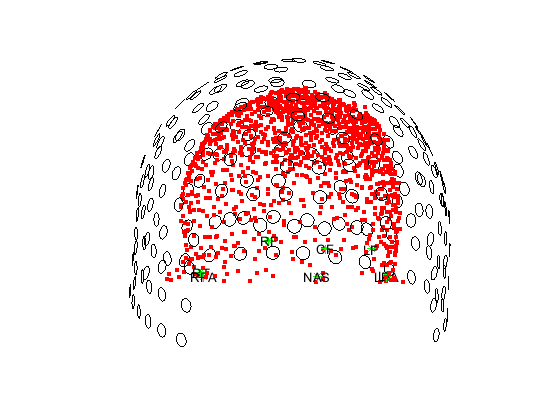

In [76]:
view([80 0]) % Front view

At this point, we have coregistered the sensors locations with the digitized headshape.
We computed the transformation from sensor space to digitized headshape space knowing which points from the HPI coils should match which stylus points from the laser scan.
Then, this transformation was applied to the sensors.
As a sanity check, lets plot the sensors, headshape, HPI coils locations and the stylus points.
`ft_transform_geometry` does not allow us to apply the transformation to the HPI_coils position themselves, we will need to apply the transformation differently.
We propose two ways below

In [38]:
% Extract the first 3x3 submatrix corresponding to the rotation matrix
rotation_matrix = transform_mrk2laser(1:3, 1:3);

% Extract the translation vector corresponding to the last column and removing the last element
translation_vector = transform_mrk2laser(1:3, 4);

% Display the results
disp('Rotation matrix:');
disp(rotation_matrix);

disp('Translation vector:');
disp(translation_vector);

Rotation matrix:
    0.9602   -0.0355    0.2771
    0.0384    0.9993   -0.0051
   -0.2767    0.0155    0.9608

Translation vector:
   16.7548
   -5.3949
   42.4524



In [39]:
% Apply the transformation to the transpose of p_coils

p_coils_t = rotation_matrix*p_coils'+ translation_vector

p_coils_t = 3x5 double
  104.4093   -1.9115    1.9115   87.3524   97.7621
    4.7914   74.7645  -74.7645   41.7716  -27.7891
   21.3170   -0.5097    0.5097   24.0880   25.6129

In [40]:
% Set back the positions of the p_coils to the transformed coordinates
p_coils = p_coils_t'

p_coils = 5x3 double
  104.4093    4.7914   21.3170
   -1.9115   74.7645   -0.5097
    1.9115  -74.7645    0.5097
   87.3524   41.7716   24.0880
   97.7621  -27.7891   25.6129

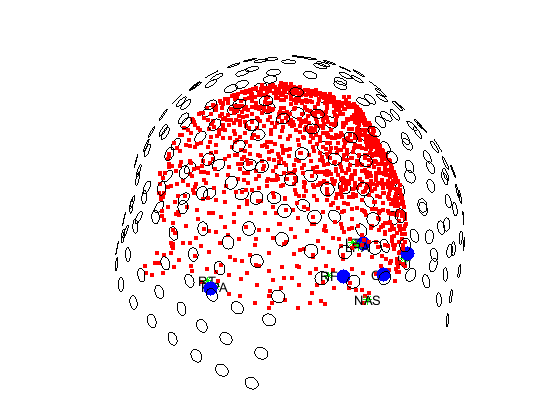

In [41]:
figure
ft_plot_headshape(headshape)
ft_plot_sens(grad)
hold on
plot3(p_coils(:,1), p_coils(:,2), p_coils(:,3), 'bo', 'MarkerSize', 10, 'MarkerFaceColor', 'b', 'LineStyle', 'none')
%plot3(p_headscan(:,1), p_headscan(:,2), p_headscan(:,3), 'bo', 'MarkerSize', 10, 'MarkerFaceColor', 'b', 'LineStyle', 'none')
view([50 20])
hold on

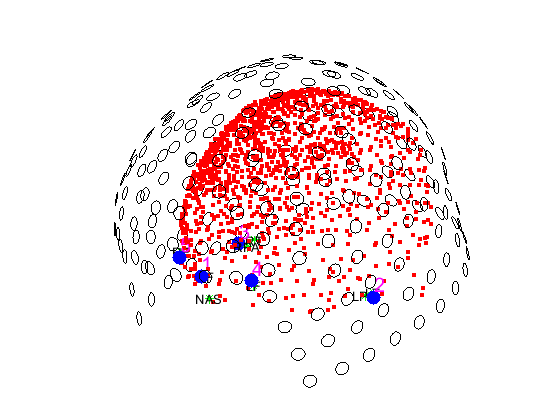

In [108]:
view([140 20])

Another way is to use what is described here: https://www.fieldtriptoolbox.org/faq/homogenous/, in which we would multiply the rigid body transformation matrix with the transpose of the p_coils (while adding an identity vector at the bottom row).

In [81]:
% Assume p_coils is already defined

p_coils = mrka.fid.pos(1:5,:);

% Create a column vector of ones
num_points = size(p_coils, 1);
ones_column = ones(num_points, 1);

% Concatenate the column of ones to p_coils
p_coils_with_ones = [p_coils, ones_column];

% Transpose the resulting matrix
p_coils_transposed = p_coils_with_ones';

% Display the result
disp('Original p_coils:');
disp(p_coils);

disp('p_coils with ones added and transposed:');
disp(p_coils_transposed);

Original p_coils:
   90.4042    6.7430    3.9254
   -2.9621   80.0952  -46.8581
   -5.3097  -69.4416  -44.0606
   74.6782   44.3433    1.6745
   81.5830  -25.5108    6.3767

p_coils with ones added and transposed:
   90.4042   -2.9621   -5.3097   74.6782   81.5830
    6.7430   80.0952  -69.4416   44.3433  -25.5108
    3.9254  -46.8581  -44.0606    1.6745    6.3767
    1.0000    1.0000    1.0000    1.0000    1.0000



In [82]:
p_coils_t = transform_mrk2laser * p_coils_transposed


p_coils_t = 4x5 double
  104.4093   -1.9115    1.9115   87.3524   97.7621
    4.7914   74.7645  -74.7645   41.7716  -27.7891
   21.3170   -0.5097    0.5097   24.0880   25.6129
    1.0000    1.0000    1.0000    1.0000    1.0000

In [83]:
p_coils = p_coils_t'
save p_coils p_coils

p_coils = 5x4 double
  104.4093    4.7914   21.3170    1.0000
   -1.9115   74.7645   -0.5097    1.0000
    1.9115  -74.7645    0.5097    1.0000
   87.3524   41.7716   24.0880    1.0000
   97.7621  -27.7891   25.6129    1.0000

Let us view display the order of appearence of each label

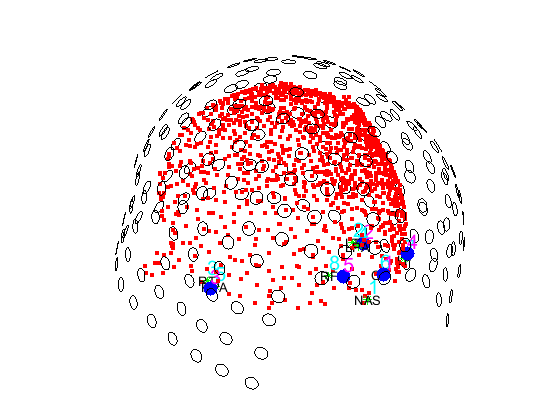

In [123]:
figure
ft_plot_headshape(headshape)
ft_plot_sens(grad)
hold on
plot3(p_coils(:,1), p_coils(:,2), p_coils(:,3), 'bo', 'MarkerSize', 10, 'MarkerFaceColor', 'b', 'LineStyle', 'none')
% Add row numbers near each point
for i = 1:size(p_coils, 1)
    text(p_coils(i, 1), p_coils(i, 2), p_coils(i, 3), num2str(i), 'FontSize', 15, 'Color', 'magenta', 'HorizontalAlignment', 'left', 'VerticalAlignment', 'bottom');
end
for i = 1:size(p_headscan, 1)
    text(p_headscan(i, 1), p_headscan(i, 2), p_headscan(i, 3), num2str(i), 'FontSize', 15, 'Color', 'cyan', 'HorizontalAlignment', 'left', 'VerticalAlignment', 'bottom');
end
%plot3(p_headscan(:,1), p_headscan(:,2), p_headscan(:,3), 'bo', 'MarkerSize', 10, 'MarkerFaceColor', 'b', 'LineStyle', 'none')
view([50 20])

Remove the last column in p_coils that was added to match the dimensions.

In [103]:
p_coils = p_coils(:, 1:end-1);
save p_coils p_coils

Let us measure the relative error of coregistration as the average distance between stylus points and HPI coil positions
The correspondance between stylus point order and .mrk order (remind that MATLAB start indexing at 0):
Point 4 stylus is HPI coil position 2 in mrk
5 is 3
6 is 1
7 is 4
8 is 5

In [5]:
relative_error = norm(p_coils(1,:) - p_headscan(6,:)) + ...
                 norm(p_coils(2,:) - p_headscan(4,:)) + ...
                 norm(p_coils(3,:) - p_headscan(5,:)) + ...
                 norm(p_coils(4,:) - p_headscan(7,:)) + ...
                 norm(p_coils(5,:) - p_headscan(8,:));

disp(['Relative error (in mm): ', num2str(relative_error/5)]);

Relative error (in mm): 6.811


Coregistration: MRI and headshape 
---------------------------------

Now that the digitized headshape is aligned with the sensors, we will proceed to align the MRI with the headshape.
Two strategies are possible
- use manually picked fiducials on the MRI for coregistration
- use an interative algorithm (ICP) to match MRI headshape with laser headshape
- use fiducials followed by ICP

**Strategy 1: manually picked fiducials on MRI**

Remind that the headshape coordinate system has been set as `CTF` which is a RAS coordinate system.

In [ ]:
load headshape headshape

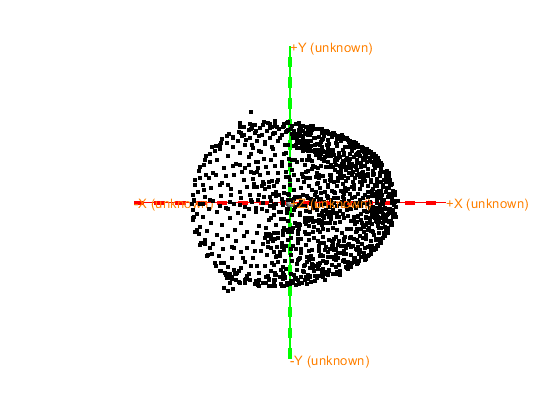

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm


ans = struct with fields:
      pos: [1251x3 double]
      fid: [1x1 struct]
    label: []
     unit: 'mm'
      cfg: [1x1 struct]

In [49]:
ft_determine_coordsys(headshape, 'interactive', 'no')

cfg = struct with fields:
         grad: [1x1 struct]
    headshape: [1x1 struct]

cfg = struct with fields:
         grad: [1x1 struct]
    headshape: [1x1 struct]
          mri: [1x1 struct]
         mesh: [1x1 struct]
         axes: 'yes'

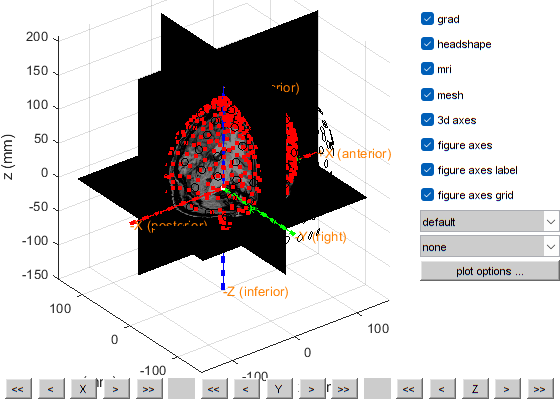

the template coordinate system is "ctf"
the positive X-axis is pointing to anterior
the positive Y-axis is pointing to the left
the positive Z-axis is pointing to superior
plotting anatomy
The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm

Press "h" to show this help.
Press "q" to quit.
Click and hold the left mouse button to rotate.
the call to "ft_geometryplot" took 1 seconds


In [58]:
load mri_init mri_init
load headshape headshape
load grad grad

cfg = [];
cfg.grad              = grad;   %structure, see FT_READ_SENS
cfg.headshape         = headshape   %structure, see FT_READ_HEADSHAPE
cfg.mri               = mri_init;
cfg.mesh              = headshape;
cfg.axes              = 'yes'

ft_geometryplot(cfg)

Since the headshape and MRI are both in CTF coordinates, no further adjustments are needed.

In [55]:
%% check how good the co-registration is
cfg                     = [];
cfg.method              = 'headshape';
cfg.headshape.headshape = headshape;
cdf.headshape.icp       = 'no';
[mri_aligned]           = ft_volumerealign(cfg, mri_init);

the input is volume data with dimensions [256 256 256]
voxel size along 1st dimension (i) : 1.000000 mm
voxel size along 2nd dimension (j) : 1.000000 mm
voxel size along 3rd dimension (k) : 1.000000 mm
volume per voxel                   : 1.000000 mm^3


 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 296

the input is volume data with dimensions [256 256 256]
voxel size along 1st dimension (i) : 1.000000 mm
voxel size along 2nd dimension (j) : 1.000000 mm
voxel size along 3rd dimension (k) : 1.000000 mm
volume per voxel                   : 1.000000 mm^3
creating scalpmask ... using the anatomy field for segmentation
smoothing anatomy with a 2-voxel FWHM kernel
thresholding anatomy at a relative threshold of 0.100
the call to "ft_volumesegment" took 1 seconds
triangulating the boundary of compartment 1 (scalp) with 20000 vertices
the call to "ft_prepare_mesh" took 1 seconds
doing interactive realignment with headshape
Use the mouse to rotate the geometry, and click "redisplay" to update the light.
Close the figure when you are done.
the template coordinate system is unknown, selecting the viewpoint is not possible

Press "h" to show this help.
Press "q" or close the window when you are done.
Press "v" to update the

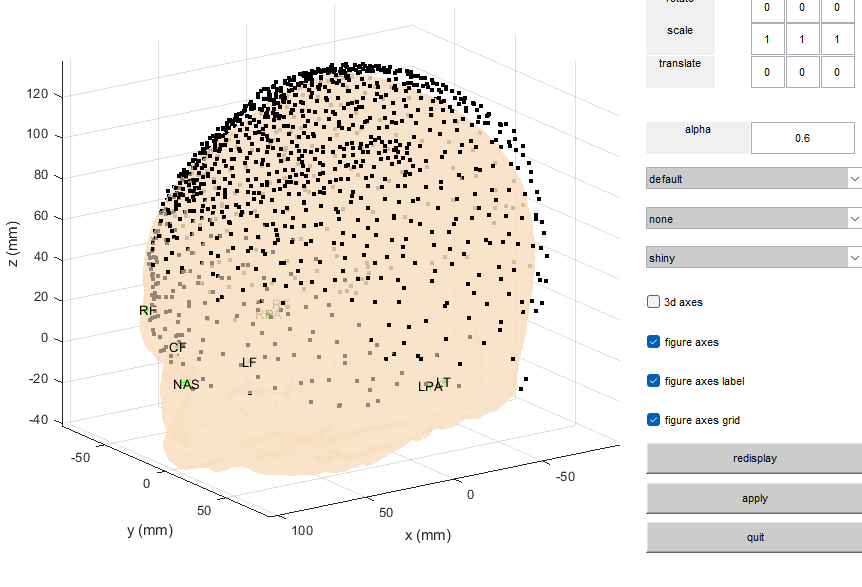

In [56]:
save mri_aligned mri_aligned

cfg = struct with fields:
         grad: [1x1 struct]
    headshape: [1x1 struct]

cfg = struct with fields:
         grad: [1x1 struct]
    headshape: [1x1 struct]
          mri: [1x1 struct]
         mesh: [1x1 struct]
         axes: 'yes'

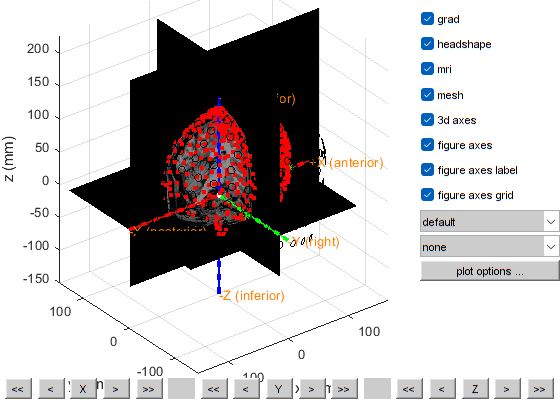

the template coordinate system is "ctf"
the positive X-axis is pointing to anterior
the positive Y-axis is pointing to the left
the positive Z-axis is pointing to superior
this returns a light skin, you can also explicitly specify 'skin_light',' skin_medium_light', 'skin_medium', 'skin_medium_dark', or 'skin_dark'
plotting anatomy
The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm

Press "h" to show this help.
Press "q" to quit.
Click and hold the left mouse button to rotate.
the call to "ft_geometryplot" took 1 seconds


In [57]:
cfg = [];
cfg.grad              = grad;   %structure, see FT_READ_SENS
cfg.headshape         = headshape   %structure, see FT_READ_HEADSHAPE
cfg.mri               = mri_aligned;
cfg.mesh              = headshape;
cfg.axes              = 'yes'

ft_geometryplot(cfg)

A good alignment is visually seen at this stage from MRI, headshape and sensor space.

**Strategy 2: Iterative ICP to match two meshes**

This is not an exact operation since ICP is an optimisation algorithm and can fall into local minima rather than the needed global minima


cfg =

     []



cfg = struct with fields:
       method: 'headshape'
    headshape: [1x1 struct]

cfg = struct with fields:
       method: 'headshape'
    headshape: [1x1 struct]

the input is volume data with dimensions [256 256 256]
voxel size along 1st dimension (i) : 1.000000 mm
voxel size along 2nd dimension (j) : 1.000000 mm
voxel size along 3rd dimension (k) : 1.000000 mm
volume per voxel                   : 1.000000 mm^3


 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 296

the input is volume data with dimensions [256 256 256]
voxel size along 1st dimension (i) : 1.000000 mm
voxel size along 2nd dimension (j) : 1.000000 mm
voxel size along 3rd dimension (k) : 1.000000 mm
volume per voxel                   : 1.000000 mm^3


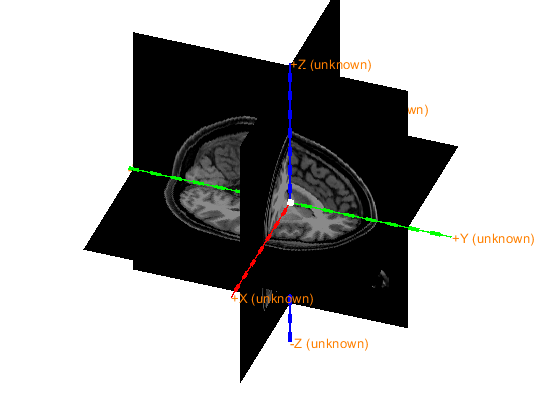

The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm
The coordinate system is not specified.
creating scalpmask ... using the anatomy field for segmentation
smoothing anatomy with a 2-voxel FWHM kernel
thresholding anatomy at a relative threshold of 0.100
the call to "ft_volumesegment" took 7 seconds
triangulating the boundary of compartment 1 (scalp) with 20000 vertices
the call to "ft_prepare_mesh" took 1 seconds
doing interactive realignment with headshape
Use the mouse to rotate the geometry, and click "redisplay" to update the light.
Close the figure when you are done.
the template coordinate system is unknown, selecting the viewpoint is not possible
this returns a light skin, you can also explicitly specify 'skin_light',' skin_medium_light', 'skin_medium', 'skin_medium_dark', or 'skin_dark'

Press "h" to show this help.
Press "q" or close the window when you are done.
Press "v" to update the light position.
the call to "ft_interactiverealig


            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdatfield.m' at line 45
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 266
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 782




            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdatfield.m' at line 45
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 266
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 782




            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 268
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 782




            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 268
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 782

interpolating distance
the call to "ft_sourceinterpolate" took 0 seconds
the input is mesh data with 20000 vertices and 39996 triangles
the input is source data with 20000 brainordinates
the input is source data with 1187 brainordinates



            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdatfield.m' at line 45
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 266
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 786




            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdatfield.m' at line 45
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 266
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 786




            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 268
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 786




            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 268
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 786

interpolating distance
the call to "ft_sourceinterpolate" took 0 seconds
the call to "ft_volumerealign" took 24 seconds


mri_aligned_icp = struct with fields:
              dim: [256 256 256]
          anatomy: [256x256x256 double]
              hdr: [1x1 struct]
        transform: [4x4 double]
             unit: 'mm'
    transformorig: [4x4 double]
         coordsys: 'unknown'
              cfg: [1x1 struct]

In [67]:
%% align MRI and Laser
load mri mri
cfg = []
cfg.method = 'headshape';
cfg.headshape = headshape;
cfg.headshape.interactive = 'no'
cfg.headshape.icp = 'yes'
mri_aligned_icp = ft_volumerealign(cfg,mri)

**Strategy 3: Fiducial fitting then ICP**

In [68]:
%% align MRI and Laser
load mri_init mri_init
cfg = []
cfg.method = 'headshape';
cfg.headshape = headshape;
cfg.headshape.interactive = 'no'
cfg.headshape.icp = 'yes'
mri_aligned_icp_fid = ft_volumerealign(cfg,mri_init)
save mri_aligned_icp_fid mri_aligned_icp_fid


cfg =

     []



cfg = struct with fields:
       method: 'headshape'
    headshape: [1x1 struct]

cfg = struct with fields:
       method: 'headshape'
    headshape: [1x1 struct]

the input is volume data with dimensions [256 256 256]
voxel size along 1st dimension (i) : 1.000000 mm
voxel size along 2nd dimension (j) : 1.000000 mm
voxel size along 3rd dimension (k) : 1.000000 mm
volume per voxel                   : 1.000000 mm^3


 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 296

the input is volume data with dimensions [256 256 256]
voxel size along 1st dimension (i) : 1.000000 mm
voxel size along 2nd dimension (j) : 1.000000 mm
voxel size along 3rd dimension (k) : 1.000000 mm
volume per voxel                   : 1.000000 mm^3
creating scalpmask ... using the anatomy field for segmentation
smoothing anatomy with a 2-voxel FWHM kernel
thresholding anatomy at a relative threshold of 0.100
the call to "ft_volumesegment" took 1 seconds
triangulating the boundary of compartment 1 (scalp) with 20000 vertices
the call to "ft_prepare_mesh" took 2 seconds
doing interactive realignment with headshape
Use the mouse to rotate the geometry, and click "redisplay" to update the light.
Close the figure when you are done.
the template coordinate system is unknown, selecting the viewpoint is not possible
this returns a light skin, you can also explicitly specify 'skin_light',' skin_medium_light', 'skin_me


            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdatfield.m' at line 45
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 266
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 782




            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdatfield.m' at line 45
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 266
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 782




            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 268
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 782




            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 268
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 782

interpolating distance
the call to "ft_sourceinterpolate" took 0 seconds
the input is mesh data with 20000 vertices and 39996 triangles
the input is source data with 20000 brainordinates
the input is source data with 1187 brainordinates



            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdatfield.m' at line 45
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 266
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 786




            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdatfield.m' at line 45
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 266
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 786




            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 268
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 786




            fid: [1x1 struct]
          label: []
           unit: 'mm'
            cfg: [1x1 struct]
    interactive: 'no'
            icp: 'yes'
       distance: [1187x1 double]
            pos: [1187x3 double]



 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 789
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\private\getdimord.m' at line 739
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_datatype_source.m' at line 268
 In 'C:\Users\hz3752\Documents\fieldtrip\utilities\ft_checkdata.m' at line 293
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_sourceinterpolate.m' at line 168
 In 'C:\Users\hz3752\Documents\fieldtrip\ft_volumerealign.m' at line 786

interpolating distance
the call to "ft_sourceinterpolate" took 0 seconds
the call to "ft_volumerealign" took 17 seconds


mri_aligned_icp_fid = struct with fields:
              dim: [256 256 256]
          anatomy: [256x256x256 double]
              hdr: [1x1 struct]
        transform: [4x4 double]
             unit: 'mm'
              cfg: [1x1 struct]
    transformorig: [4x4 double]
         coordsys: 'ctf'

The following window should open, make a sanity check of the correct alignment.

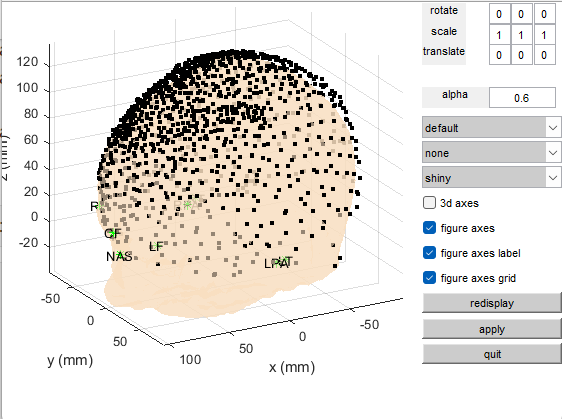

Computing the head conductor model
==================================

Segmentation of brain, skull and scalp boundaries given the aligned MRI.

In [70]:
load mri_aligned_icp_fid mri_aligned_icp_fid
mri_aligned = mri_aligned_icp_fid
%% segmentation MRI
cfg           = [];
cfg.output    = {'brain', 'skull', 'scalp'};
segmentedmri  = ft_volumesegment(cfg, mri_aligned);

save segmentedmri segmentedmri

mri_aligned = struct with fields:
              dim: [256 256 256]
          anatomy: [256x256x256 double]
              hdr: [1x1 struct]
        transform: [4x4 double]
             unit: 'mm'
              cfg: [1x1 struct]
    transformorig: [4x4 double]
         coordsys: 'ctf'

the input is volume data with dimensions [256 256 256]
voxel size along 1st dimension (i) : 1.000000 mm
voxel size along 2nd dimension (j) : 1.000000 mm
voxel size along 3rd dimension (k) : 1.000000 mm
volume per voxel                   : 1.000000 mm^3
using 'OldNorm' normalisation
the coordinate system appears to be 'mni152'
Smoothing by 0 & 8mm..
Coarse Affine Registration..


Fine Affine Registration..
performing the segmentation on the specified volume, using the old-style segmentation

SPM12: spm_preproc                                 16:27:18 - 29/07/2024


Completed                               :          16:27:40 - 29/07/2024
creating scalpmask ... using the anatomy field for segmentation
smoothing anatomy with a 5-voxel FWHM kernel
thresholding anatomy at a relative threshold of 0.100
creating brainmask ... using the sum of gray, white and csf tpms
smoothing brainmask with a 5-voxel FWHM kernel
thresholding brainmask at a relative threshold of 0.500
creating skullmask ... using the brainmask
the call to "ft_volumesegment" took 51 seconds


In [71]:
cfg = [];
cfg.method='singleshell';
mriskullmodel = ft_prepare_headmodel(cfg, segmentedmri);

triangulating the boundary of compartment 1 (brain) with 3000 vertices
the call to "ft_prepare_mesh" took 1 seconds
the call to "ft_prepare_headmodel" took 1 seconds


In [72]:
cfg = [];
cfg.tissue      = {'brain', 'skull', 'scalp'};
cfg.numvertices = [3000 2000 1000];
mesh = ft_prepare_mesh(cfg, segmentedmri);
% ft_plot_mesh(mesh(3), 'facecolor', 'none'); % scalp

save mriskullmodel mriskullmodel

triangulating the boundary of compartment 1 (brain) with 3000 vertices
triangulating the boundary of compartment 2 (skull) with 2000 vertices
triangulating the boundary of compartment 3 (scalp) with 1000 vertices
the call to "ft_prepare_mesh" took 3 seconds


Plot the final coregistration result and make sure everything aligns well visually.

cfg = struct with fields:
         grad: [1x1 struct]
    headshape: [1x1 struct]

cfg = struct with fields:
         grad: [1x1 struct]
    headshape: [1x1 struct]
    headmodel: [1x1 struct]

cfg = struct with fields:
         grad: [1x1 struct]
    headshape: [1x1 struct]
    headmodel: [1x1 struct]
          mri: [1x1 struct]
         mesh: [1x1 struct]
         axes: 'yes'

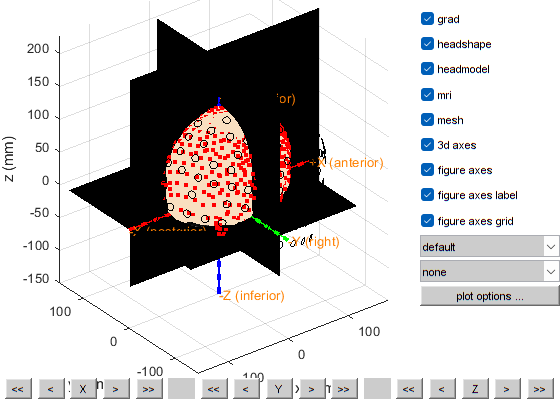

the template coordinate system is "ctf"
the positive X-axis is pointing to anterior
the positive Y-axis is pointing to the left
the positive Z-axis is pointing to superior
this returns a light skin, you can also explicitly specify 'skin_light',' skin_medium_light', 'skin_medium', 'skin_medium_dark', or 'skin_dark'
plotting anatomy
The axes are 150 mm long in each direction
The diameter of the sphere at the origin is 10 mm

Press "h" to show this help.
Press "q" to quit.
Click and hold the left mouse button to rotate.
the call to "ft_geometryplot" took 1 seconds


In [73]:
load grad grad
cfg = [];
%   cfg.elec              = structure, see FT_READ_SENS
   cfg.grad              = grad;%structure, see FT_READ_SENS
%   cfg.opto              = structure, see FT_READ_SENS
  cfg.headshape         = mesh(3)%structure, see FT_READ_HEADSHAPE
  cfg.headmodel         = mriskullmodel% structure, see FT_PREPARE_HEADMODEL and FT_READ_HEADMODEL
%   cfg.sourcemodel       = structure, see FT_PREPARE_SOURCEMODEL
%   cfg.dipole            = structure, see FT_DIPOLEFITTING
  cfg.mri               = mri_aligned;
  cfg.mesh              = headshape;
  cfg.axes              = 'yes'

ft_geometryplot(cfg)

Defining trials and epoching
============================

Ways to improve this notebook
-----------------------------

- Find a tolerable threshold for the relative_error of coregistration
- To align the MRI with the headshape, ICP is used, it would be better to find the transformation based on fiducials (headshape fiducial are known, MRI fiducials are manually picked in previous steps) and apply the transformation to coregister, we can then apply ICP after the fiducial fitting, this would help us avoid wrong local minima
- generate a coregistration report, showing different metrics (e.g., relative_error) the measured value, the minimum required thresholds, and how many metrics verify or not the requirements
- check how the MRI slices are indexed from 0 to some value, whether the 0 slice correspond to the right or left part of the head, this can impact the selection of fiducials on the MRI